Ref: https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = [12, 6]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################
plt.rcParams.update({'axes.grid'     : True})

## Import data

In [3]:
data = pd.read_csv('../data/num_file/hrs_01/p040.csv')

In [4]:
print(data)

                 datetime  count
0     2022-04-21 01:00:00   1033
1     2022-04-21 02:00:00     65
2     2022-04-21 03:00:00      0
3     2022-04-21 04:00:00      0
4     2022-04-21 05:00:00      0
...                   ...    ...
3246  2022-09-03 07:00:00   9741
3247  2022-09-03 08:00:00  19613
3248  2022-09-03 09:00:00  22055
3249  2022-09-03 10:00:00  14644
3250  2022-09-03 11:00:00  12751

[3251 rows x 2 columns]


If there is no people, use NaN.

In [5]:
data.loc[data['count']==0, 'count'] = np.NaN

In [6]:
print(data)

                 datetime    count
0     2022-04-21 01:00:00   1033.0
1     2022-04-21 02:00:00     65.0
2     2022-04-21 03:00:00      NaN
3     2022-04-21 04:00:00      NaN
4     2022-04-21 05:00:00      NaN
...                   ...      ...
3246  2022-09-03 07:00:00   9741.0
3247  2022-09-03 08:00:00  19613.0
3248  2022-09-03 09:00:00  22055.0
3249  2022-09-03 10:00:00  14644.0
3250  2022-09-03 11:00:00  12751.0

[3251 rows x 2 columns]


<Axes: >

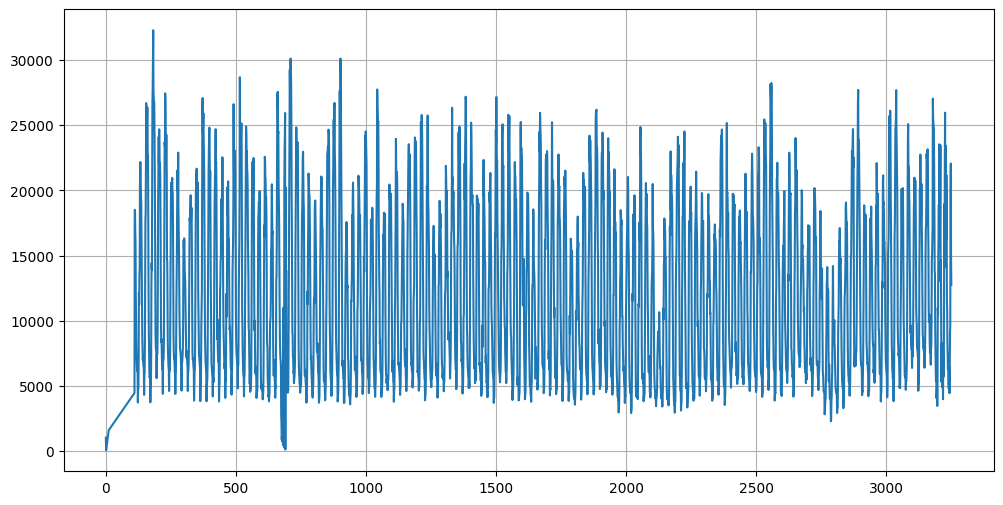

In [7]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

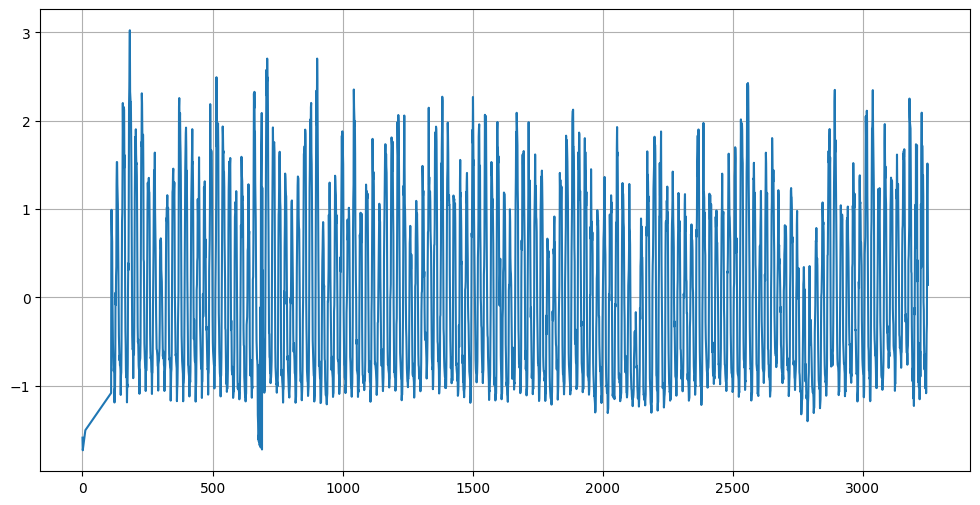

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [9]:
print(data)

                 datetime     count
0     2022-04-21 01:00:00 -1.588140
1     2022-04-21 02:00:00 -1.730996
2     2022-04-21 03:00:00 -1.708284
3     2022-04-21 04:00:00 -1.685572
4     2022-04-21 05:00:00 -1.662859
...                   ...       ...
3246  2022-09-03 07:00:00 -0.303021
3247  2022-09-03 08:00:00  1.153879
3248  2022-09-03 09:00:00  1.514267
3249  2022-09-03 10:00:00  0.420559
3250  2022-09-03 11:00:00  0.141192

[3251 rows x 2 columns]


In [10]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 12

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [11]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [12]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

## Model

In [13]:
from keras.layers import Input, LSTM, BatchNormalization, RepeatVector, TimeDistributed, Dense, dot, multiply, concatenate, Activation, GRU
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [14]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [15]:
'''
lstm_1 = LSTM(32, return_sequences=True, return_state=False)(input_train)
norm_lstm_1 = BatchNormalization()(lstm_1)
'''

'\nlstm_1 = LSTM(32, return_sequences=True, return_state=False)(input_train)\nnorm_lstm_1 = BatchNormalization()(lstm_1)\n'

In [16]:
# encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, activation='relu', return_sequences=False, return_state=True)(input_train)
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, return_sequences=False, return_state=True)(input_train)

In [17]:
encoder_last_h1 = BatchNormalization()(encoder_last_h1)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [18]:
decoder = RepeatVector(time_step)(encoder_last_h1)
# decoder = LSTM(32, activation='relu', return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])
decoder = LSTM(32, return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

In [19]:
# lstm_decode = LSTM(32, return_sequences=True, return_state=False)(decoder)

In [20]:
out = TimeDistributed(Dense(1))(decoder)

In [21]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 32),         4352        ['input_1[0][0]']                
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 batch_normalization (BatchNorm  (None, 32)          128         ['lstm[0][0]']                   
 alization)                                                                                   

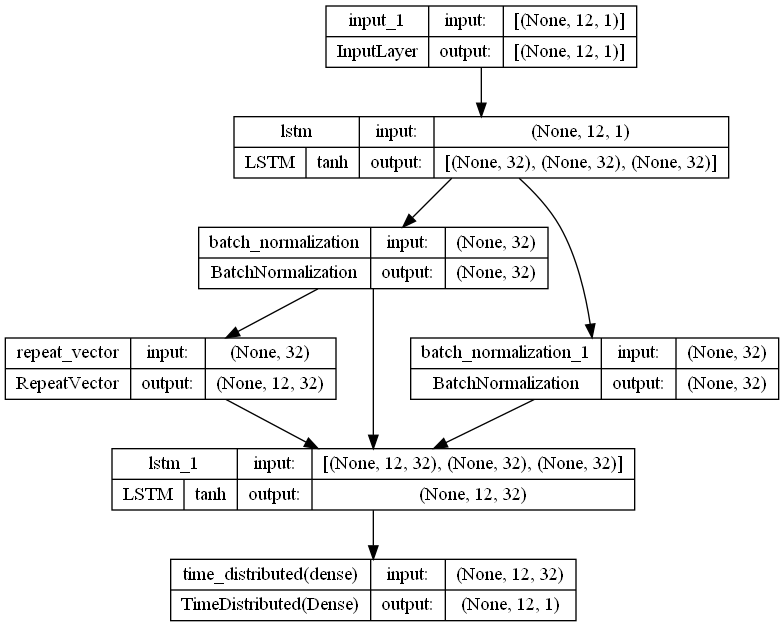

In [22]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_activations=True)

In [23]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es], shuffle=True)

Epoch 1/100
19/19 [==============================] - 2s 27ms/step - loss: 0.3353 - mae: 0.4265 - val_loss: 0.3630 - val_mae: 0.5123
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1331 - mae: 0.2650 - val_loss: 0.2997 - val_mae: 0.4665
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0919 - mae: 0.2173 - val_loss: 0.3141 - val_mae: 0.4721
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0745 - mae: 0.1974 - val_loss: 0.2657 - val_mae: 0.3962
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0686 - mae: 0.1872 - val_loss: 0.2371 - val_mae: 0.3810
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0612 - mae: 0.1760 - val_loss: 0.1689 - val_mae: 0.3079
Epoch 7/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0619 - mae: 0.1756 - val_loss: 0.1251 - val_mae: 0.2772
Epoch 8/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0666 - 

In [24]:
# model.save('./params/p040_seq2seq.keras')

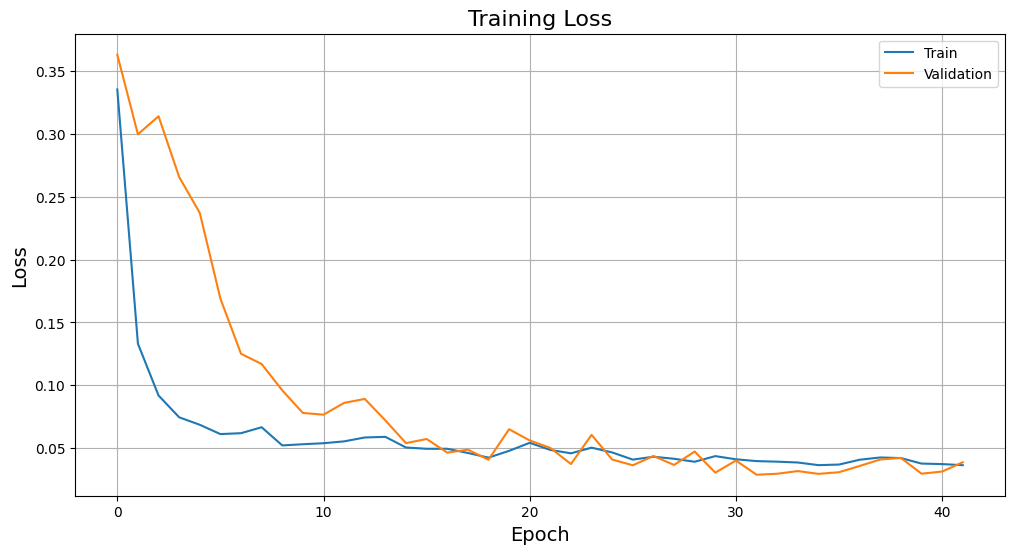

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [26]:
predict_train = model.predict(encode_input_data_train)

81/81 [==============================] - 0s 2ms/step


In [27]:
predict_test = model.predict(encode_input_data_test)

21/21 [==============================] - 0s 2ms/step


In [28]:
print(predict_train.shape)

(2590, 12, 1)


In [29]:
print(predict_test.shape)

(648, 12, 1)


In [30]:
predict = np.concatenate([predict_train, predict_test], axis=0)
print(predict.shape)

(3238, 12, 1)


In [31]:
print(predict_test[:, -1, :])

[[ 4.35962260e-01]
 [ 8.22150886e-01]
 [ 8.99072528e-01]
 [ 9.20696497e-01]
 [ 5.26518524e-01]
 [ 5.56487858e-01]
 [ 6.70680463e-01]
 [ 8.62828553e-01]
 [ 7.04917192e-01]
 [ 1.62085980e-01]
 [-4.10256386e-01]
 [-6.28259540e-01]
 [-7.06726968e-01]
 [-7.84979165e-01]
 [-8.27881515e-01]
 [-8.39870691e-01]
 [-8.58959258e-01]
 [-8.81411850e-01]
 [-8.25616002e-01]
 [-5.32307863e-01]
 [-2.55302578e-01]
 [ 1.57122165e-01]
 [ 8.10092032e-01]
 [ 7.87866533e-01]
 [ 1.16753590e+00]
 [ 1.46600819e+00]
 [ 1.66102839e+00]
 [ 1.54117060e+00]
 [ 1.24857104e+00]
 [ 1.09103310e+00]
 [ 9.88068044e-01]
 [ 9.41042006e-01]
 [ 3.46037775e-01]
 [-3.05438221e-01]
 [-6.78259373e-01]
 [-7.93364346e-01]
 [-8.34483087e-01]
 [-8.19631994e-01]
 [-8.39749217e-01]
 [-9.06699359e-01]
 [-9.66888070e-01]
 [-9.05400455e-01]
 [-8.51731598e-01]
 [-7.02394068e-01]
 [-5.54364741e-01]
 [ 1.62706524e-02]
 [ 6.25147045e-01]
 [ 8.89801085e-01]
 [ 1.23892736e+00]
 [ 1.40455043e+00]
 [ 1.72782516e+00]
 [ 1.54694664e+00]
 [ 1.3626166

In [32]:
print(decode_output_data_test[:, -1, :])

[[ 0.31725334]
 [ 0.46807914]
 [ 0.58378113]
 [ 0.24907181]
 [ 0.76220422]
 [ 0.92395087]
 [ 1.20435109]
 [ 0.80544488]
 [ 0.10060727]
 [-0.27468629]
 [-0.39333986]
 [-0.46343991]
 [-0.66252407]
 [-0.80242902]
 [-0.8223522 ]
 [-0.83917621]
 [-0.8498019 ]
 [-0.9696361 ]
 [-0.85216317]
 [-0.81674419]
 [-0.46270202]
 [ 0.25984508]
 [ 0.18856439]
 [ 0.8603443 ]
 [ 1.19874309]
 [ 1.63734807]
 [ 1.51559534]
 [ 1.20139951]
 [ 1.18029571]
 [ 1.16007737]
 [ 1.17852476]
 [ 0.55884027]
 [-0.13699502]
 [-0.58224106]
 [-0.60113118]
 [-0.7560892 ]
 [-0.76671489]
 [-0.89451836]
 [-0.88492572]
 [-0.93333165]
 [-0.93613565]
 [-1.1240038 ]
 [-1.07692608]
 [-1.05287069]
 [-0.64437184]
 [ 0.09145737]
 [ 0.34942557]
 [ 0.93738057]
 [ 1.08274595]
 [ 1.80248904]
 [ 1.58156318]
 [ 1.35886637]
 [ 1.40358283]
 [ 1.30632823]
 [ 1.44003486]
 [ 1.01943453]
 [ 0.7179305 ]
 [ 0.51013918]
 [-0.18525338]
 [-0.40485102]
 [-0.54254229]
 [-0.636255  ]
 [-0.644667  ]
 [-0.66267165]
 [-0.64850406]
 [-0.7898848 ]
 [-0.68111

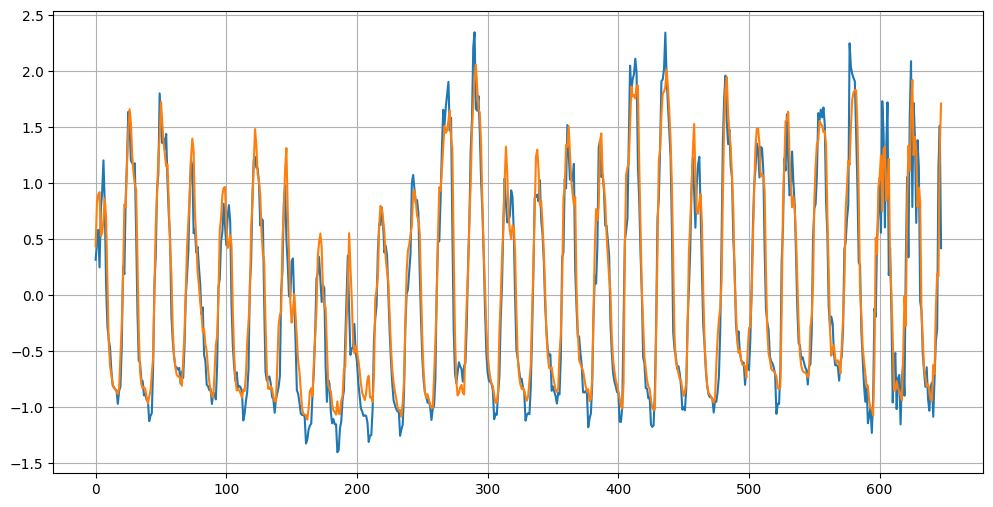

In [33]:
plt.plot(np.arange(decode_output_data_test.shape[0]), decode_output_data_test[:, -1, :])
plt.plot(np.arange(predict_test.shape[0]), predict_test[:, -1, :])
plt.show()

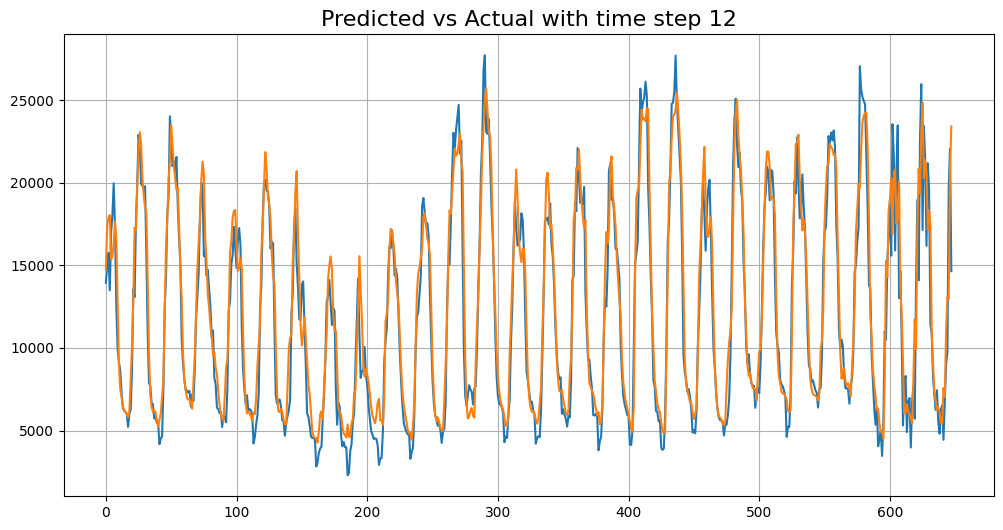

In [34]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'Predicted vs Actual with time step {time_step}')
plt.show()

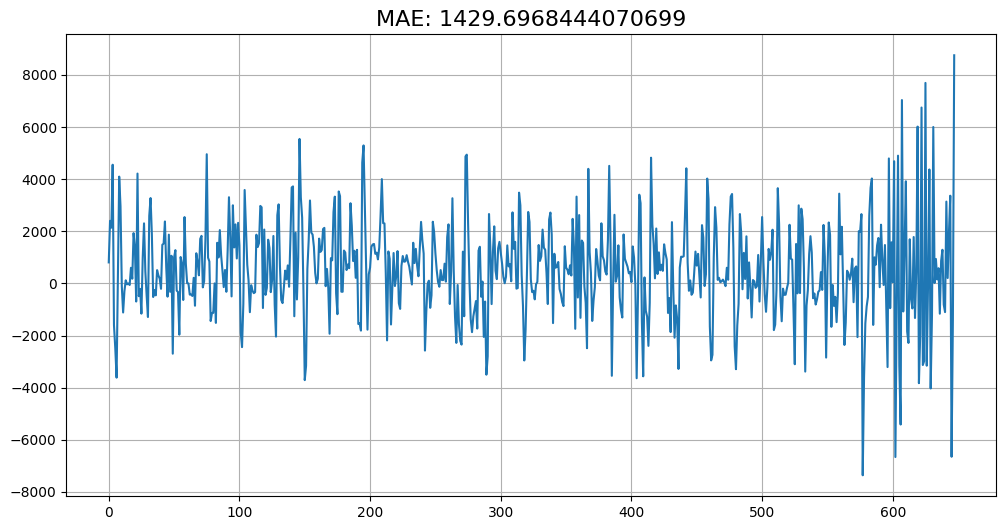

In [35]:
from sklearn.metrics import mean_absolute_error
plt.title('MAE: {}'.format(mean_absolute_error(decode_output_test_data, predict_test_data)))
plt.plot(np.arange(decode_output_test_data.shape[0]), predict_test_data-decode_output_test_data)
plt.show()